In [1]:
%qtconsole

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib2
import xml.etree.ElementTree as ET
from datetime import date, datetime, timedelta, time
from bs4 import BeautifulSoup
import json
import re
from dateutil import tz
from os import listdir
from os.path import isfile, join, isdir
from os import path, mkdir
from IPython.html import widgets
from IPython.html.widgets import interact, interactive
import mpld3
mpld3.enable_notebook()

//anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


ImportError: No module named mpld3

In [4]:
# Extract javascript vars and save them to dictionary

def scan_file(f):
    
    d = dict()
    
    soup = BeautifulSoup(f.decode('utf8'))
    js = soup.find_all('script')
    
    # Find GPS coordinates
    m = re.search(".*,lat:(?P<lat>.*),lng:(?P<lon>.*),date.*", f)
    if m:
        d.update({u'lat' : m.groups()[0], u'lon' : m.groups()[1]})
        
    # Find time zone
    m = re.search(".*,tz:'(?P<tz>.*)',install.*", f)
    if m:
        d.update({u'tz' : m.groups()[0]})
    
    matcher_rex = re.compile(r'var\s+(?P<varname>\w+)\s+=\s+(?P<varvalue>[\S]+);?$')
    for j in js:
        p = j.get_text().splitlines()
        for pp in p:
                            
            matches = matcher_rex.match(pp.strip())
            if matches:

                name, value = matches.groups()
                value = value.rstrip(';')
                value = value.rstrip("'")
                if len(value)>0:
                    if value[0] == '[':
                        value = value[1:-1].split(',')
                        for i, v in enumerate(value):
                            try:
                                value[i] = float(v)
                            except:
                                pass
                            if v == u'null':
                                value[i] = np.nan

                d.update({name : value})
        
    return d

In [5]:

def to_datetime(utcTime, fmt="'%H:%M%p'"):
    uctTime = utcTime.strip("'")
    if uctTime[-2:] == 'AM':
        return datetime.combine(data_date, datetime.strptime(utcTime, "'%I:%MAM'").time())
        #return datetime.strptime(utcTime, "'%I:%MAM'")
    if uctTime[-2:] == 'PM':
        return datetime.combine(data_date, (datetime.strptime(utcTime, "'%I:%MPM'") + timedelta(hours=12)).time())
        #return datetime.strptime(utcTime, "'%I:%MPM'") + timedelta(hours=12)
    return 0

# Create pandas dataframe, numeric and string variables dictionaries
def toStructure(d, data_date):

    M = max([len(x) for x in d.values()])
    p = pd.DataFrame({'TimeStamp': d['cats']})
    p['TimeStamp'] = p['TimeStamp'].map(to_datetime)
    p = p.set_index('TimeStamp')

    num_dict = dict()
    str_dict = dict()

    for i in range(len(d)):
        if len(d.values()[i])==M:
            try:
                p[d.keys()[i]] = d.values()[i]
            except:
                pass
        else:
            try:
                num_dict[d.keys()[i]]= float(d[d.keys()[i]])
            except:
                str_dict[d.keys()[i]]= d[d.keys()[i]]
    return p, num_dict, str_dict

In [6]:
def download(url):
    u = urllib2.urlopen(url)
    f = u.read()
    u.close()
    return scan_file(f)

In [7]:
# Login
import urllib2, urllib
import webbrowser
testMemberIds = []

opener = urllib2.build_opener(urllib2.HTTPCookieProcessor())
urllib2.install_opener(opener)

loginParams = urllib.urlencode( {
'login' : 'uc3m_IDE4L',
'password' : 'uc3m_IDE4L',
} )
opener.open( 'http://pvoutput.org/',  loginParams)

<addinfourl at 4618434104 whose fp = <socket._fileobject object at 0x113462cd0>>

In [8]:
# Id of the client
sid = '25563' 

# Last date to retrieve
a = date.today()

# Number of days to retrieve
numdays = 15

# If directories do not exist, create them
if not path.isdir(sid):
    mkdir(sid)
    mkdir(join(sid, 'data'))
elif not path.isdir(join(sid, 'data')):
    mkdir(join(sid, 'data'))

for x in range (0, numdays):
    
    data_date = a - timedelta(days = x)
    data_date_str = data_date.strftime('%Y%m%d')
    print data_date_str
    
    #Download html+js
    url = 'http://pvoutput.org/intraday.jsp?id=15594&sid='+sid+'&dt='+data_date_str+'&gs=0&m='+str(0)
    url = 'http://pvoutput.org/intraday.jsp?id=15594&sid='+sid+'&dt='+data_date_str
    
    #Parse html+js
    d = download(url)
    
    if len(d)==0:
        print 'Empty response from server'
        continue
    
    #Covert variables to DataFrames as dictionaries
    p, num_dict, str_dict = toStructure(d, data_date)
    
    #Save data
    with open(join(sid, 'data', 'numdata'+data_date_str+'.json'), 'wb') as fp:
        json.dump(num_dict, fp)

    with open(join(sid, 'data', 'strdata'+data_date_str+'.json'), 'wb') as fp:
        json.dump(str_dict, fp)
    
    p.to_csv(join(sid, 'data', 'tsdata'+data_date_str+'.csv'))


20150403
20150402
20150401
20150331
20150330
20150329
20150328
20150327
20150326
20150325
20150324
20150323
20150322
20150321
20150320


In [9]:
# Read files
files = [ f for f in listdir(join(sid, 'data')) if isfile(join(sid, 'data', f)) and f[:2]=='ts' and f[-3:]=='csv' ]
df = pd.DataFrame()
for i, f in enumerate(files):
    dff = pd.read_csv(join(sid, 'data', f)).set_index('TimeStamp')
    if 'cats' in dff:
        if i==0:
            df = dff
        else:
            df = pd.concat([df, dff],axis=0,ignore_index=False)

df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.asfreq('5min')

# Read json files
onlyfiles = [ f for f in listdir(join(sid, 'data')) if isfile(join(sid, 'data', f)) and f[:3]=='str']
for f in onlyfiles:
    with open(join(sid, 'data', f), 'r') as fp:
        str_dict = json.loads(fp.read())
        
onlyfiles = [ f for f in listdir(join(sid, 'data')) if isfile(join(sid, 'data', f)) and f[:3]=='num']
for f in onlyfiles:
    with open(join(sid, 'data', f), 'r') as fp:
        num_dict = json.loads(fp.read())

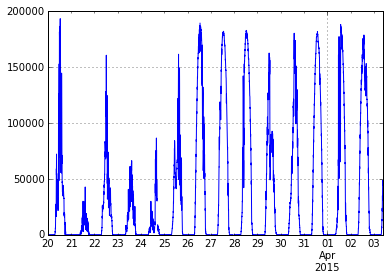

In [10]:
df.loc[:, 'dataPowerOut'].plot()

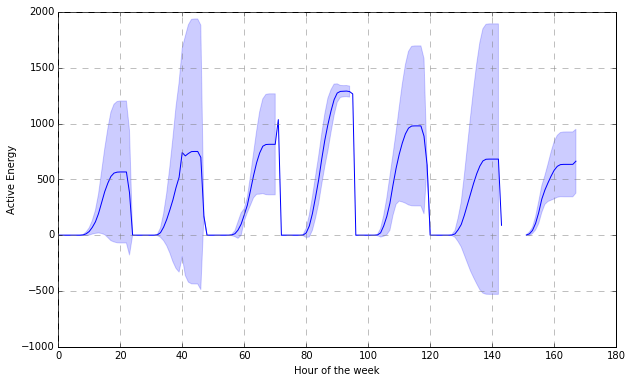

In [11]:
grouped = df['dataEnergyOut'].to_frame().astype(np.float).groupby([lambda x: x.weekday,lambda x: x.hour])
m = grouped.transform(lambda x: x.mean())
st = grouped.transform(lambda x: x.std())
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(color='gray', linestyle='dashed')
ax.plot(grouped.mean())
lim_sup = grouped.mean()-2*grouped.std()
lim_inf = grouped.mean()+2*grouped.std()
ax.fill_between(np.arange(len(grouped)),lim_sup.values.ravel(), lim_inf.values.ravel(), color='b', alpha=0.2)
plt.xlabel('Hour of the week')
plt.ylabel('Active Energy')

# Solar Radiation

In [12]:
def lst2lt(lst, day, longitude, tgmt):
    lstm = 15.0 * tgmt
    B = np.deg2rad((360.0 / 365.0) * (day - 81.))
    eot = 9.87 * np.sin(2.*B) - 7.53*np.cos(B) - 1.5*np.sin(B)
    tc = 4.*(longitude - lstm) + eot
    lt = lst - (tc / 60.)
    return lt

def lst2lt(lst, day, longitude, tgmt):
    lstm = 15.0 * tgmt
    B = np.deg2rad((360.0 / 365.0) * (day - 81.))
    eot = 9.87 * np.sin(2.*B) - 7.53*np.cos(B) - 1.5*np.sin(B)
    tc = 4.*(longitude - lstm) + eot
    lt = lst - (tc / 60.)
    return lt

def Declination(c):
    return 23.45*np.sin(np.deg2rad((360./365.)*(c-81.)))

def AM(c,e,f):
    f = np.deg2rad(f)
    dec=np.deg2rad(Declination(e))
    HRA=np.deg2rad(15.*(c-12.))
    elevation=np.arcsin(np.sin(dec)*np.sin(f)+np.cos(dec)*np.cos(f)*np.cos(HRA))
    declination=np.deg2rad(90.)-elevation
    return 1./(1e-4+np.cos(declination))

def SunRiseSet(day, latitude):
    
    dec = np.deg2rad(Declination(day))
    lat = np.deg2rad(latitude)
    x = - (np.sin(lat) * np.sin(dec))
    x = x / (np.cos(lat) * np.cos(dec))
    if (x > 1.0):
        x = 1.0
    if (x < -1.0):
        x = -1.0
    ff = np.arccos(x)
    H = np.rad2deg(ff / 15.0)

    sunrise = 12.0 - H
    sunset = 12.0 + H
    
    return sunrise, sunset

def Insolation(hour, day, latitude):
    sunrise, sunset = SunRiseSet(day, latitude)
    if (hour > sunrise and hour < sunset):
        am = AM(hour, day, latitude)
        x1 = 0.7**am
        Stot = 1.353 * x1**0.678
    else:
        Stot = 0
    if (Stot > 1.1):
        Stot = 0

    return Stot

In [13]:
time_zone = tz.gettz(str_dict['tz'])
tgmt = time_zone.utcoffset(datetime.now()).seconds / 3600.0

ins = pd.DataFrame(np.zeros(len(df)), index=df.index, columns=['Insolation'])

for i in range(len(ins)):
    lt = ins.index[i].hour + ins.index[i].minute / 60.
    day = ins.index[i].dayofyear
    dt = lst2lt(12., day, num_dict['lon'], tgmt)-12
    lst = lt 
    ins.loc[ins.index[i], 'Insolation'] = Insolation(lt, day, num_dict['lat'])

df['Insolation'] = ins

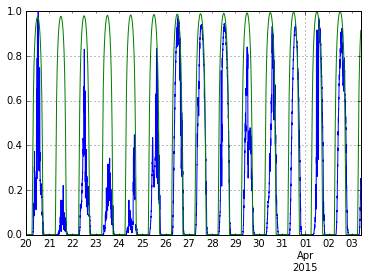

In [14]:
(df['dataPowerOut'] / df['dataPowerOut'].max()).plot()
df.Insolation.plot()